# Normalization with ANT to the 1st level output(Applynorm function)

In [9]:
import os
from os.path import join as opj
from nipype import Workflow, Node, MapNode
from nipype.interfaces.ants import ApplyTransforms
from nipype.interfaces.utility import IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.interfaces.fsl import Info

In [10]:
#set dir
experiment_dir = '/data/wellbeing_analysis'
output_dir = 'datasink'
working_dir = 'workingdir'

# task name
task_list = ['empathy']

# Smoothing withds used during normalization
fwhm = [4, 8]

# MNI template
template = '/home/zohyos7/fmri/mni_icbm152_nlin_asym_09c/1mm_T1.nii.gz'

In [11]:
#subject list
subject_list = os.listdir("/data/wellbeing_bids")
subject_list.remove('dataset_description.json')
subject_list = [sub[-4:] for sub in subject_list]

In [12]:
# Apply Transformation Node
apply2con = MapNode(ApplyTransforms(args='--float',
                                    input_image_type=3,
                                    interpolation='BSpline',
                                    invert_transform_flags=[False],
                                    num_threads=5,
                                    reference_image=template,
                                    terminal_output='file'),
                    name='apply2con', iterfield=['input_image'])


In [13]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id', 'task_name','fwhm_id']),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list),
                        ('task_name', task_list),
                        ('fwhm_id', fwhm)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
templates = {'con': opj('/data/wellbeing_analysis/datasink/1stLevel', 'sub-{subject_id}', 'task-{task_name}', 
                        'fwhm-{fwhm_id}','???_00??.nii'),
             'transform': opj('/data/wellbeing_analysis/datasink/antsreg', 'sub-{subject_id}', 'transformComposite.h5')}

selectfiles = Node(SelectFiles(templates,
                               base_directory=experiment_dir,
                               sort_filelist=True),
                   name="selectfiles")

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

# Use the following DataSink output substitutions
substitutions = [('_fwhm_id_%s_subject_id_%s_task_name_%s/'  % (f, sub, task),
                'sub-%s/con/task-%s/fwhm-%s/' % (sub, task, f))
               for f in fwhm
               for task in task_list
               for sub in subject_list]
subjFolders = [('_apply2con%s/' % (i), '') for i in range(20)]
substitutions.extend(subjFolders)
datasink.inputs.substitutions = substitutions

In [14]:
# Initiation of the ANTs normalization workflow
antsflow = Workflow(name='antsflow')
antsflow.base_dir = opj(experiment_dir, working_dir)

# Connect up the ANTs normalization components
antsflow.connect([(infosource, selectfiles, [('subject_id', 'subject_id'),
                                             ('task_name', 'task_name'),
                                             ('fwhm_id', 'fwhm_id')]),
                  (selectfiles, apply2con, [('con', 'input_image'),
                                             ('transform', 'transforms')]),
                  (apply2con, datasink, [('output_image', 'antsflow.@con')])
                  ])

181005-15:39:56,937 nipype.workflow INFO:
	 Generated workflow graph: /data/wellbeing_analysis/workingdir/antsflow/graph.png (graph2use=colored, simple_form=True).


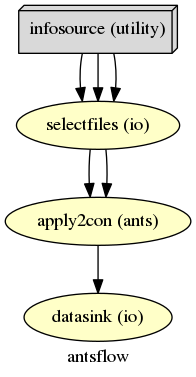

In [15]:
antsflow.write_graph(graph2use='colored', format='png', simple_form=True)


from IPython.display import Image
Image(filename='/data/wellbeing_analysis/workingdir/antsflow/graph.png')

In [16]:
antsflow.run('MultiProc', plugin_args={'n_procs':5})

181005-15:40:05,456 nipype.workflow INFO:
	 Workflow antsflow settings: ['check', 'execution', 'logging', 'monitoring']
181005-15:40:13,221 nipype.workflow INFO:
	 Running in parallel.
181005-15:40:13,272 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 498 jobs ready. Free memory (GB): 113.22/113.22, Free processors: 5/5.
181005-15:40:13,723 nipype.workflow INFO:
	 [Node] Setting-up "antsflow.selectfiles" in "/data/wellbeing_analysis/workingdir/antsflow/_fwhm_id_8_subject_id_2677_task_name_empathy/selectfiles".
181005-15:40:13,726 nipype.workflow INFO:
	 [Node] Setting-up "antsflow.selectfiles" in "/data/wellbeing_analysis/workingdir/antsflow/_fwhm_id_8_subject_id_3140_task_name_empathy/selectfiles".181005-15:40:13,725 nipype.workflow INFO:
	 [Node] Setting-up "antsflow.selectfiles" in "/data/wellbeing_analysis/workingdir/antsflow/_fwhm_id_4_subject_id_2677_task_name_empathy/selectfiles".

181005-15:40:13,728 nipype.workflow INFO:
	 [Node] Setting-up "antsflow.selectfiles" in 

RuntimeError: Workflow did not execute cleanly. Check log for details

## Compare before & after Apply_Norm